In [ ]:
import numpy as np
import joblib
import pandas as pd
import datetime
import tensorflow as tf
import os
import random
import timeit
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional, Dropout, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D, Reshape, Multiply, GRU
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError

## CBAM layer實作

In [ ]:
channel = 32
reduction = 16
channel // reduction

2

In [ ]:
class CBAMLayer(tf.keras.Model):
    def __init__(self, channel, reduction=16, spatial_kernel=7):   # 作者預設: reduction=16, spatial_kernel=7(這是論文設定值，可能有神麼意義?)
        super(CBAMLayer, self).__init__()
        self.channel = channel

        # Channel attention
        self.max_pool = GlobalMaxPooling1D()
        self.avg_pool = GlobalAveragePooling1D()

        self.mlp = tf.keras.Sequential([
            Dense(channel // reduction, use_bias=False), # 利用channel除以reduction，壓縮到縮到一個維度較低的空間
            tf.keras.layers.Activation('relu'),
            Dense(channel, use_bias=False)               # 然後再過一個回到channel數量的維度
        ])

        # Spatial attention
        self.conv = Conv1D(1, (spatial_kernel), padding='same', use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    # 這應該是繼承來overwrite(或是實作(本來可能根本沒寫(抽象方法的概念)))的方法，定義好之後因為keras每一層會自動訓練，所以裏頭也就是會去呼叫這個叫做call()的方法，所以這個名子不能去改
    def call(self, x):
        max_out = self.mlp(Reshape((1, self.channel))(self.max_pool(x))) # MLP轉換 # x是輸入的張量 # Reshape將self.max_pool(x)出來的值的形狀改成(1, self.channel)，基本上在這裡self.max_pool(x)的形狀應該會是(32,)，因為總共有32個filter，這樣做是因為TensorFlow Dense層要求的input shape 為 (#batch_size(反正就是樣本數), #input_dimension)，只有一筆所以就給1，然後是32個特徵(維)，寫法蠻神奇的要注意一下
        avg_out = self.mlp(Reshape((1, self.channel))(self.avg_pool(x))) # MLP轉換
        channel_out = self.sigmoid(max_out + avg_out)   # 經MLP轉換後的maxpooling跟averagepooling相加後，再過一個sigmoid
        x = Multiply()([channel_out, x])

        max_out = tf.reduce_max(x, axis=2, keepdims=True)
        avg_out = tf.reduce_mean(x, axis=2, keepdims=True)
        spatial_out = self.sigmoid(self.conv(tf.concat([max_out, avg_out], axis=2)))
        x = Multiply()([spatial_out, x])
        return x

In [ ]:
x = tf.random.normal((1, 32, 1024))
net = CBAMLayer(1024)
y = net.call(x)

# 輸入跟輸出的形狀是一樣的
print(f"x shape is {x.shape}")
print(f"y shape is {y.shape}")

x shape is (1, 32, 1024)
y shape is (1, 32, 1024)


### 嘗試將多變量時間序列包成input的形狀

In [ ]:
import pandas as pd

# 使用相對路徑載入資料
df = pd.read_csv('../../all_data/house_price_monthly_bfill.csv', encoding='utf-8')

In [ ]:
df

,date,house_index_xyi_all_tp,house_index_xyi_tp,house_index_xyi_new_tp,EA1101,EB0312,EB0911,EB18,EB21,EB22,...,航運業(TSE26)收盤,鋼鐵(TSE20)收盤,倫敦鋁現貨價,倫敦高級銅極現貨價,巴拿馬型貨櫃運費指數,杜拜輕原油現貨價,水泥50kg北區台泥,無鉛汽油95,竹節鋼筋_南,預拌混凝土3000磅台北
0,2011-01-31,95.40,94.45,96.84,34.0,28.8,1.0978,86.78,95.85,89.85,...,123.49,120.70,2450.300,9560.900,1738.2,91.6700,151.5,31.600,21260.0,1815.0
1,2011-02-28,97.69,97.34,98.23,34.0,28.8,1.3261,85.89,96.75,89.80,...,108.61,117.89,2513.250,9853.125,1696.0,99.7525,151.5,31.575,21250.0,1890.0
2,2011-03-31,97.76,97.86,97.61,31.0,28.8,1.3950,83.66,96.60,88.00,...,103.48,122.54,2548.875,9564.625,2071.5,109.1775,151.5,32.675,21525.0,1890.0
3,2011-04-30,97.31,98.38,95.69,29.0,28.8,1.2941,85.78,100.45,89.30,...,110.02,122.81,2682.700,9524.800,1601.0,115.6840,151.5,32.980,20500.0,1896.0
4,2011-05-31,96.85,97.02,96.60,27.0,28.8,1.6650,85.40,102.60,90.55,...,112.45,118.57,2587.625,8945.125,1755.0,105.4850,151.5,32.525,20175.0,1787.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2023-11-30,162.10,150.51,179.66,20.0,42.5,2.8952,69.40,67.42,81.84,...,138.28,139.30,2197.875,8135.500,1729.0,82.7800,169.5,31.125,20250.0,2625.0
155,2023-12-31,163.19,150.85,181.90,22.0,45.4,2.6980,70.06,67.32,81.33,...,154.46,146.64,2204.900,8450.000,2063.5,77.9300,169.5,30.960,20880.0,2625.0
156,2024-01-31,167.57,156.36,184.58,27.0,46.2,1.7954,72.14,69.24,82.94,...,149.83,141.05,2181.125,8339.375,1580.5,79.9025,169.5,30.650,20775.0,2700.0
157,2024-02-29,171.05,159.79,188.13,29.0,54.0,3.0751,73.22,70.23,83.59,...,157.14,141.65,2187.500,8314.000,1548.5,82.8375,169.5,30.600,20925.0,2700.0


In [ ]:
# 取得資料的總筆數
n = len(df)

# 設定訓練資料集的筆數為總筆數的80%
n_train = int(0.8 * n)
# 設定驗證資料集的筆數為總筆數的10%
n_val = int(0.1 * n)
# 設定測試資料集的筆數為剩餘的筆數（總筆數減去訓練和驗證資料集的筆數）
n_test = n - n_train - n_val

# 將資料前80%的資料作為訓練資料集，並移除 'date' 欄位，只保留數值部分
train_data = df[:n_train].drop(columns=['date']).values
# 將資料前80%的資料作為訓練資料集，只保留 'date' 欄位，移除其他欄位
train_date = df[:n_train][['date']]

# 將資料第80%到90%的資料作為驗證資料集，並移除 'date' 欄位，只保留數值部分
val_data = df[n_train:n_train + n_val].drop(columns=['date']).values
# 將資料第80%到90%的資料作為驗證資料集，只保留 'date' 欄位，移除其他欄位
val_date = df[n_train:n_train + n_val][['date']]

# 將資料最後10%的資料作為測試資料集，並移除 'date' 欄位，只保留數值部分
test_data = df[-n_test:].drop(columns=['date']).values
# 將資料最後10%的資料作為測試資料集，只保留 'date' 欄位，移除其他欄位
test_date = df[-n_test:][['date']]

In [ ]:
# 原始表格
# 這個形狀就是 (#samples(一個一個的時間點，以月為單位), #feature)
train_data.shape # array-like

(127, 44)

In [ ]:
len(train_data)

127

In [ ]:
# 希望 每一筆資料 以前6個月預測這個月 shape=(6,41)
# 所以是y的format要改
timestamp = 6
X_shift_list = []
y_shift_list = []
for i, x in enumerate(train_data):
    if timestamp+i < len(train_data):
        X_shift_list.append(train_data[i:timestamp+i])
        y_shift_list.append(train_data[timestamp+i, 0]) # 後面多加一個0代表取第一個經濟指標作為要預測的值y

In [ ]:
X = np.array(X_shift_list)
y = np.array(y_shift_list)

In [ ]:
print(X.shape)
print(y.shape)

(121, 6, 44)
(121,)


In [ ]:
# 提取 '倫敦高級銅極現貨價' 和 'date' 欄位
df_test = df[['date', '倫敦高級銅極現貨價']]

## step3.  Split the data into training, validation, and test sets

In [ ]:
# 取得資料的總筆數
n = len(df)

# 設定訓練資料集的筆數為總筆數的80%
n_train = int(0.8 * n)
# 設定驗證資料集的筆數為總筆數的10%
n_val = int(0.1 * n)
# 設定測試資料集的筆數為剩餘的筆數（總筆數減去訓練和驗證資料集的筆數）
n_test = n - n_train - n_val

# 將資料前80%的資料作為訓練資料集，並移除 'date' 欄位，只保留數值部分
train_data = df[:n_train].drop(columns=['date']).values
# 將資料前80%的資料作為訓練資料集，只保留 'date' 欄位，移除其他欄位
train_date = df[:n_train][['date']]

# 將資料第80%到90%的資料作為驗證資料集，並移除 'date' 欄位，只保留數值部分
val_data = df[n_train:n_train + n_val].drop(columns=['date']).values
# 將資料第80%到90%的資料作為驗證資料集，只保留 'date' 欄位，移除其他欄位
val_date = df[n_train:n_train + n_val][['date']]

# 將資料最後10%的資料作為測試資料集，並移除 'date' 欄位，只保留數值部分
test_data = df[-n_test:].drop(columns=['date']).values
# 將資料最後10%的資料作為測試資料集，只保留 'date' 欄位，移除其他欄位
test_date = df[-n_test:][['date']]

In [ ]:
train_data.shape

(127, 44)

In [ ]:
print('Train Set      : ',len(train_data))
print('Validation Set : ',len(val_data))
print('Test Set       : ',len(test_data))

Train Set      :  127
Validation Set :  15
Test Set       :  17


## Step 4. 資料正則化

In [ ]:
from sklearn.preprocessing import StandardScaler   # 這個效果應該比較好

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data) # 只有訓練資料可以fit，之後都使用訓練吃廖fit出來的結果作transform
val_data   = scaler.transform(val_data)
test_data  = scaler.transform(test_data)
# 他全部資料都拿進去標準化了(所以最後target y要進行還原還原)

############### 還原方法 ####################
# 使用之前訓練好的標準化器 (scaler) 將數值資料恢復到標準化之前的值
# original_data = scaler.inverse_transform(train_data)
# original_data

In [ ]:
# 試試看歸一化
# from sklearn.preprocessing import MinMaxScaler

# mm_scaler = MinMaxScaler()
# train_data = mm_scaler.fit_transform(train_data) # 只有訓練資料可以fit，之後都使用訓練吃廖fit出來的結果作transform
# val_data   = mm_scaler.transform(val_data)
# test_data  = mm_scaler.transform(test_data)

## step 5.

In [ ]:
# Step 5 這邊只是demo沒幹嘛
# Take day "for predict" from data test
# 預測1,3,5天後

one_day_date = test_date.head(1)
one_day_data = test_data[:1]

three_day_date = test_date.head(3)
three_day_data = test_data[:3]

five_day_date = test_date.head(5)
five_day_data = test_data[:5]

## step 6. Create a windowed dataset for training

In [ ]:
window_size = 12 # use 1 from interval one month of data for each window
def create_window_dataset(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # 後面多加一個0代表取第一個經濟指標作為要預測的值y
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = create_window_dataset(train_data, window_size)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(115, 12, 44)
(115,)


In [ ]:
# Function: create_window_dataset 解釋
# 在切資料筆數， 這一筆(第一筆)資料的輸入值
# 以前6天的資料(X)預測當天y

# X
print(f"X is day 1 to 6 {train_data[0:6].shape}")


# y
print(f"y is day 7, it is a scalar 0D shape {train_data[6, 0].shape}")

X is day 1 to 6 (6, 44)
y is day 7, it is a scalar 0D shape ()


### Data input for Conv1D in TensorFlow be like [#sample, #timestamp, #features]

## step 7. 使用滑動窗口的方法創建數據集

In [ ]:
# step 7.
# 使用滑動窗口的方法從【訓練資料集】創建輸入和輸出數據集，window_size 為窗口大小
X_train, y_train = create_window_dataset(train_data, window_size)

# 使用滑動窗口的方法從【驗證資料集】創建輸入和輸出數據集，window_size 為窗口大小
X_val, y_val = create_window_dataset(val_data, window_size)

# 使用滑動窗口的方法從【測試資料集】創建輸入和輸出數據集，window_size 為窗口大小
X_test, y_test = create_window_dataset(test_data, window_size)

In [ ]:
# 在 model.fit 方法中，輸入和輸出數據的形狀必須匹配模型的預期形狀。如果數據形狀不匹配，TensorFlow 會引發 ValueError。從錯誤信息來看，似乎有一個地方期望形狀為 (None, 1) 的張量，但得到了形狀為 (None,) 的張量。
# y要reshape (n,) -> (n,1)

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
y_test.shape

(5, 1)

## step 8. 模型訓練

In [ ]:
# step 8.1
def cc(y_true, y_pred):
    """
    計算 y_true 和 y_pred 之間的相關係數。
    """
    # 計算協方差矩陣
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # 計算 y_true 和 y_pred 的標準差
    std_true = K.std(y_true)
    std_pred = K.std(y_pred)

    # 計算相關係數
    return cov / (std_true * std_pred)

## 接下來要研究的部分
* model architect
* Optimizer
* Loss function

In [ ]:
input_shape = (window_size, 44)   ## 要注意形狀 (#timestamp, #features)

# strides=1                  # kernel_sized可以設定的大小跟window_size(時間)有關
model = Sequential([
    Conv1D(filters=32, kernel_size=2, strides=1, activation='relu', input_shape=input_shape, kernel_regularizer= tf.keras.regularizers.l2(0.01)),
    CBAMLayer(channel=32), # 看是不是這樣用(可以用...)(裡面有沒有寫對?不知道...) # 添加 CBAMLayer，這裡的 channel 應該與上一層的輸出(channel數)一致
    Conv1D(filters=32, kernel_size=2, strides=1, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01)), # 這邊出來的shape應該是 (None, 2, 4)
    # Conv1D(filters=32, kernel_size=2, strides=1, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01)), # 這邊出來的shape應該是 (None, 2, 4)
    Dropout(0.5),
    MaxPooling1D(pool_size=2),
    # Flatten(),  # 添加 Flatten 層

    # BiLSTM要吃2維的
    Bidirectional(GRU(5, return_sequences=True)),
    # Dropout(0.5),     # 這代表說從上面的Bidirectional到下面的Bidirectional時，前面的那層neuron(隨機(p=<數值，這裡就是0.5>)被不啟動，也就是給權重給0的意思)，換個方式講可能比較好: Dropout也是一層但它的作用就是隨機把上一層的一些輸出*權重0(等於是deactive這些被挑到的neurons)，用來避免overfittin
    Bidirectional(GRU(5, return_sequences=True)),
    Flatten(),
    Dense(128, activation='relu', name='target_layer'),  # 數字是輸出時的向量長度(neurons數量)
    # Dense(n_features),  # 輸出層的單元數應該等於特徵數量
    Dense(1)
])

c:\Users\Tony\anaconda3\envs\dl\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.MeanSquaredError(),       # Huber() # MeanSquaredError
              metrics= [RootMeanSquaredError(), cc])

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, verbose=1,
                               mode='min',
                               restore_best_weights=True)

In [ ]:
# !pip install ops

In [ ]:
# LearningRateScheduler
import ops
import math
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_Scheduler = LearningRateScheduler(scheduler)


In [ ]:
# y要reshape
y_train.shape

(115, 1)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_Scheduler]) # keras.callbacks module下的物件，在建立模型時都是以list的形式給的

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 481ms/step - cc: 0.4390 - loss: 1.2803 - root_mean_squared_error: 0.7659 - val_cc: -0.8487 - val_loss: 10.3151 - val_root_mean_squared_error: 3.1050 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - cc: 0.7862 - loss: 1.1805 - root_mean_squared_error: 0.7125 - val_cc: -0.7768 - val_loss: 9.2122 - val_root_mean_squared_error: 2.9257 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - cc: 0.7694 - loss: 0.9536 - root_mean_squared_error: 0.5524 - val_cc: -0.7717 - val_loss: 7.7849 - val_root_mean_squared_error: 2.6745 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - cc: 0.8892 - loss: 0.8310 - root_mean_squared_error: 0.4491 - val_cc: -0.7181 - val_loss: 6.1174 - val_root_mean_squared_error: 2.3461 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - cc: 0.9189 - loss: 0.6958 - root_mean_squared_error: 0.2935 - val_cc: -0.7140 - val_loss: 4.6237 - val_roo

In [ ]:
# 這可以看每一層的shape(記一下)
from keras.utils import plot_model
model.summary()
plot_model(model, to_file='convolutional_neural_network.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image('convolutional_neural_network.png')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 11, 32)         │         2,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_layer_1 (CBAMLayer)        │ (None, 11, 32)         │           142 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 5, 10)          │         1,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 5, 10)          │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ target_layer (Dense)            │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,223 (157.12 KB)

 Trainable params: 13,407 (52.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,816 (104.75 KB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


FileNotFoundError: No such file or directory: 'convolutional_neural_network.png'

FileNotFoundError: No such file or directory: 'convolutional_neural_network.png'

<IPython.core.display.Image object>

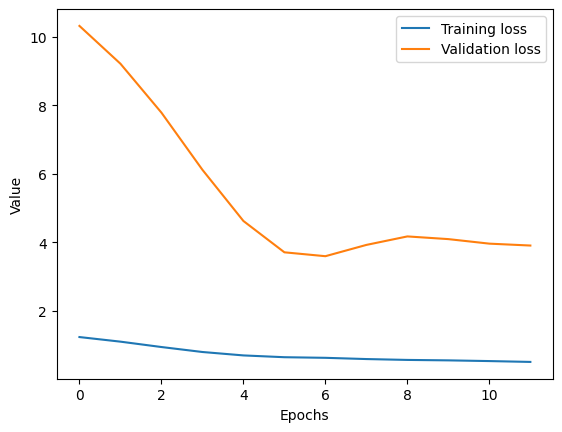

In [ ]:
### Loss下降情況 (training, validation)

# Plot the training and validation metrics
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

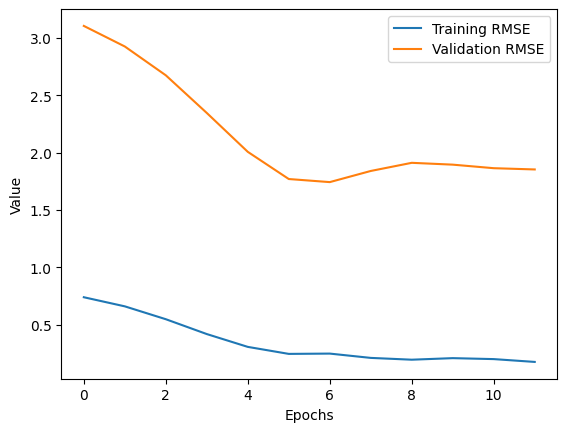

In [ ]:
### RMSE下降情況 (training, validation)

plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

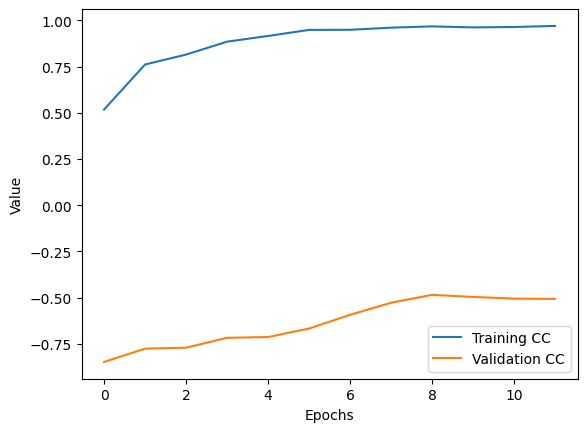

In [ ]:
### 兩者的相關係數 (training, validation)

plt.plot(history.history['cc'], label='Training CC')
plt.plot(history.history['val_cc'], label='Validation CC')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_rmse, test_cc = model.evaluate(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_train)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cc: 0.9478 - loss: 0.6029 - root_mean_squared_error: 0.2128 
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step


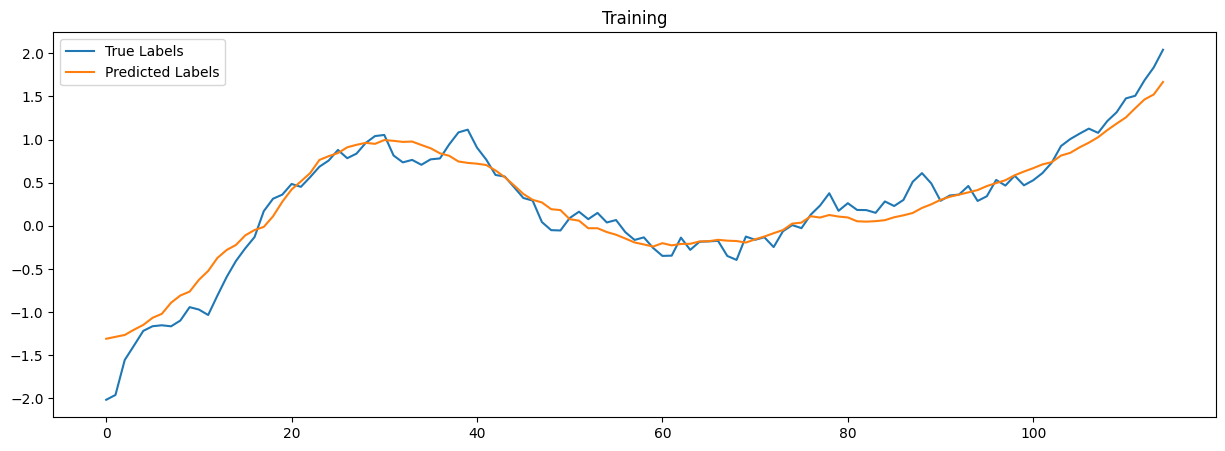

In [ ]:
#
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='True Labels')
plt.plot(y_pred, label='Predicted Labels')
plt.legend()
plt.title('Training')
# plt.savefig('training_plot.png') # 輸出圖片成檔案(要放在plt.show()之前否則會輸出空白圖表)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - cc: -0.9445 - loss: 7.6044 - root_mean_squared_error: 2.6547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


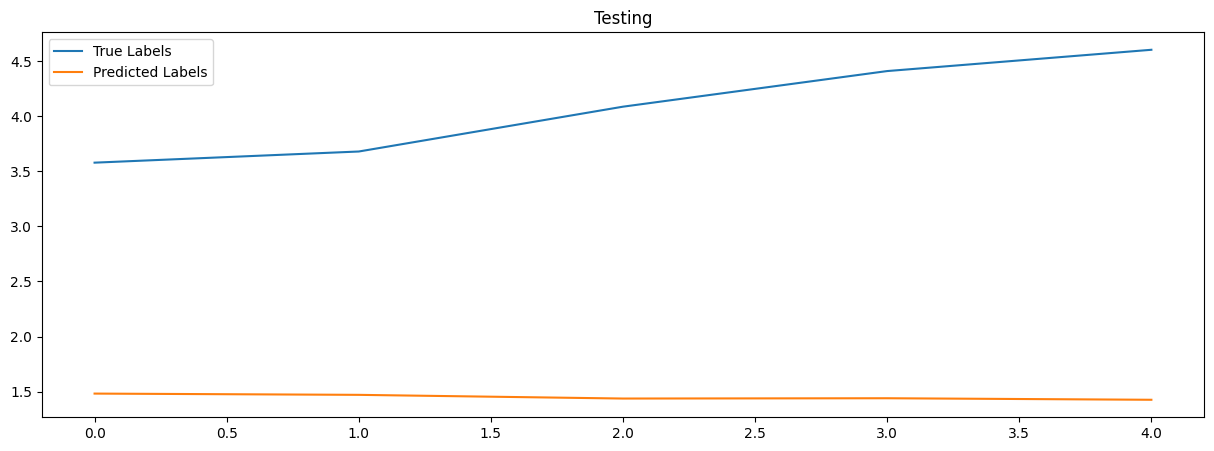

In [ ]:
# Evaluate the model on the test set
test_loss, test_rmse, test_cc = model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

#
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True Labels')
plt.plot(y_pred_test, label='Predicted Labels')
plt.legend()
plt.title('Testing')
plt.show()

In [ ]:
# import matplotlib.pyplot as plt # 之後研究一下

# # 示例數據
# time_train = range(1, 51)  # 假設訓練集有50個時間點
# time_test = range(51, 101)  # 假設測試集有50個時間點
# y_train = [i + (i % 10) for i in time_train]  # 假設的訓練集真實資料
# y_test = [i + (i % 10) for i in time_test]  # 假設的測試集真實資料
# y_pred_train = [i + (i % 8) for i in time_train]  # 假設的訓練集預測資料
# y_pred_test = [i + (i % 8) for i in time_test]  # 假設的測試集預測資料

# # 繪圖
# plt.figure(figsize=(14, 7))
# plt.plot(time_train, y_train, label='Training True Data', color='blue')
# plt.plot(time_test, y_test, label='Testing True Data', color='blue', linestyle='dashed')
# plt.plot(time_train, y_pred_train, label='Training Predicted Data', color='orange')
# plt.plot(time_test, y_pred_test, label='Testing Predicted Data', color='orange', linestyle='dashed')

# # 添加標籤和標題
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('True Data vs Predicted Data')
# plt.legend()
# plt.grid(True)
# plt.show()
